In [80]:
# Professor allowed me to use other small dataset because my laptop is getting stuck while implement Food101 dataset which large.
# Dataset - https://www.kaggle.com/datasets/prasunroy/natural-images
#https://www.kaggle.com/code/androbomb/using-cnn-to-classify-images-w-pytorch/notebook

In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil
from torchvision.datasets.utils import download_url

In [ ]:
!unzip archive\ \(1\).zip

In [76]:
# The images are in a folder named 'input/natural-images/natural_images'
training_folder_name = 'data/natural_images'

# All images are 128x128 pixels
img_size = (128,128)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [77]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.12.1+cu113


In [78]:
from PIL import Image

# function to resize image
def resize_image(src_image, size=(128,128), bg_color="white"): 
    from PIL import Image, ImageOps 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

In [79]:
training_folder_name = 'data/natural_images'

# New location for the resized images
train_folder = '../working/data/natural_images'


# Create resized copies of all of the source images
size = (128,128)

# Create the output folder if it doesn't already exist
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

# Loop through each subfolder in the input folder
print('Transforming images...')
for root, folders, files in os.walk(training_folder_name):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        # Create a matching subfolder in the output dir
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the files in the subfolder
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
            # Open the file
            file_path = os.path.join(root,sub_folder, file_name)
            #print("reading " + file_path)
            image = Image.open(file_path)
            # Create a resized version and save it
            resized_image = resize_image(image, size)
            saveAs = os.path.join(saveFolder, file_name)
            #print("writing " + saveAs)
            resized_image.save(saveAs)

print('Done.')

Transforming images...
processing folder fruit
processing folder person
processing folder dog
processing folder airplane
processing folder car
processing folder flower
processing folder cat
processing folder motorbike
Done.


In [82]:
def load_dataset(data_path):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Recall that we have resized the images and saved them into
train_folder = '../working/data/natural_images'

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Data loaders ready to read ../working/data/natural_images


In [97]:
# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)



Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=8, bias=True)
)


In [98]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [99]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [100]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 2.096908
	Training batch 2 Loss: 8.235077
	Training batch 3 Loss: 3.078918
	Training batch 4 Loss: 1.751477
	Training batch 5 Loss: 1.677387
	Training batch 6 Loss: 1.656644
	Training batch 7 Loss: 1.850467
	Training batch 8 Loss: 1.294575
	Training batch 9 Loss: 1.424000
	Training batch 10 Loss: 1.468080
	Training batch 11 Loss: 1.182117
	Training batch 12 Loss: 0.919348
	Training batch 13 Loss: 1.215258
	Training batch 14 Loss: 0.993055
	Training batch 15 Loss: 1.112877
	Training batch 16 Loss: 0.975883
	Training batch 17 Loss: 0.815488
	Training batch 18 Loss: 0.702881
	Training batch 19 Loss: 0.737119
	Training batch 20 Loss: 0.815104
	Training batch 21 Loss: 1.088435
	Training batch 22 Loss: 0.769292
	Training batch 23 Loss: 0.860663
	Training batch 24 Loss: 1.493040
	Training batch 25 Loss: 0.835068
	Training batch 26 Loss: 0.796367
	Training batch 27 Loss: 0.798620
	Training batch 28 Loss: 0.920298
	Training batch 29 Loss: 0.89827

Getting predictions from test set...


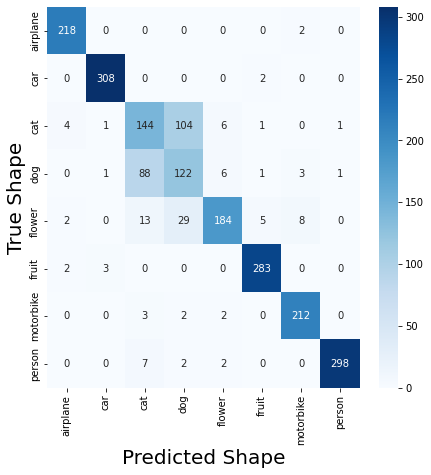

In [101]:
# Defining Labels and Predictions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

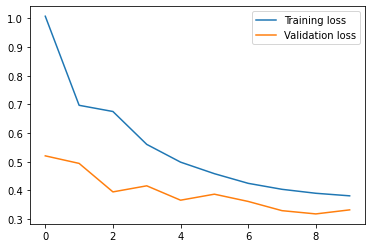

In [102]:
# plotting the training and validation loss
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend()
plt.show()

In [103]:
class Allconvo(nn.Module):
    def __init__(self):
        super(Allconvo, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x


In [96]:
model = Allconvo() # On CPU
#model = Net().to(device)  # On GPU
print(model)

Allconvo(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


In [104]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [105]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [106]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 0.246028
	Training batch 2 Loss: 0.317498
	Training batch 3 Loss: 0.398813
	Training batch 4 Loss: 0.292781
	Training batch 5 Loss: 0.275676
	Training batch 6 Loss: 0.234841
	Training batch 7 Loss: 0.316944
	Training batch 8 Loss: 0.470033
	Training batch 9 Loss: 0.185267
	Training batch 10 Loss: 0.427671
	Training batch 11 Loss: 0.203388
	Training batch 12 Loss: 0.254126
	Training batch 13 Loss: 0.423377
	Training batch 14 Loss: 0.366853
	Training batch 15 Loss: 0.383312
	Training batch 16 Loss: 0.329504
	Training batch 17 Loss: 0.418749
	Training batch 18 Loss: 0.425040
	Training batch 19 Loss: 0.274665
	Training batch 20 Loss: 0.457213
	Training batch 21 Loss: 0.270890
	Training batch 22 Loss: 0.505458
	Training batch 23 Loss: 0.326593
	Training batch 24 Loss: 0.513826
	Training batch 25 Loss: 0.312812
	Training batch 26 Loss: 0.499818
	Training batch 27 Loss: 0.454931
	Training batch 28 Loss: 0.292242
	Training batch 29 Loss: 0.31081

In [132]:
#L1 Regularization
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 * 1, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  def compute_l1_loss(self, w):
      return torch.abs(w).sum()
  
  
if __name__ == '__main__':
  
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Prepare CIFAR-10 dataset
  dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)
  
  # Initialize the MLP
  mlp = MLP()
  
  # Define the loss function and optimizer
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
  
  # Run the training loop
  for epoch in range(0, 5): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = loss_function(outputs, targets)
      
      # Compute L1 loss component
      l1_weight = 1.0
      l1_parameters = []
      for parameter in mlp.parameters():
          l1_parameters.append(parameter.view(-1))
      l1 = l1_weight * mlp.compute_l1_loss(torch.cat(l1_parameters))
      
      # Add L1 loss component
      loss += l1
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      minibatch_loss = loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.5f (of which %.5f L1 loss)' %
                (i + 1, minibatch_loss, l1))
          current_loss = 0.0

  # Process is complete.
  print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 65.46844 (of which 63.18564 L1 loss)
Loss after mini-batch  1000: 13.96671 (of which 11.65112 L1 loss)
Loss after mini-batch  1500: 3.68985 (of which 1.38492 L1 loss)
Loss after mini-batch  2000: 2.93928 (of which 0.63669 L1 loss)
Loss after mini-batch  2500: 2.93661 (of which 0.63402 L1 loss)
Loss after mini-batch  3000: 2.94112 (of which 0.63853 L1 loss)
Loss after mini-batch  3500: 2.93957 (of which 0.63699 L1 loss)
Loss after mini-batch  4000: 2.93565 (of which 0.63306 L1 loss)
Loss after mini-batch  4500: 2.94100 (of which 0.63842 L1 loss)
Loss after mini-batch  5000: 2.93991 (of which 0.63732 L1 loss)
Loss after mini-batch  5500: 2.93886 (of which 0.63627 L1 loss)
Loss after mini-batch  6000: 2.93798 (of which 0.63539 L1 loss)
Starting epoch 2
Loss after mini-batch   500: 2.94104 (of which 0.63846 L1 loss)
Loss after mini-batch  1000: 2.93711 (of which 0.63452 L1 loss)
Loss after mini-batch  1500: 2.93915 (of which 0.63656 L1 loss)
Lo

In [133]:
#L2 Regularization
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 * 1, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  def compute_l2_loss(self, w):
      return torch.square(w).sum()
  
  
if __name__ == '__main__':
  
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Prepare CIFAR-10 dataset
  dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)
  
  # Initialize the MLP
  mlp = MLP()
  
  # Define the loss function and optimizer
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
  
  # Run the training loop
  for epoch in range(0, 5): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = loss_function(outputs, targets)
      
      # Compute l2 loss component
      l2_weight = 1.0
      l2_parameters = []
      for parameter in mlp.parameters():
          l2_parameters.append(parameter.view(-1))
      l2 = l2_weight * mlp.compute_l2_loss(torch.cat(l2_parameters))
      
      # Add l2 loss component
      loss += l2
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      minibatch_loss = loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.5f (of which %.5f l2 loss)' %
                (i + 1, minibatch_loss, l2))
          current_loss = 0.0

  # Process is complete.
  print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 6.90672 (of which 4.62813 l2 loss)
Loss after mini-batch  1000: 3.57362 (of which 1.24972 l2 loss)
Loss after mini-batch  1500: 2.59496 (of which 0.29211 l2 loss)
Loss after mini-batch  2000: 2.35297 (of which 0.05843 l2 loss)
Loss after mini-batch  2500: 2.30740 (of which 0.00982 l2 loss)
Loss after mini-batch  3000: 2.30312 (of which 0.00131 l2 loss)
Loss after mini-batch  3500: 2.30289 (of which 0.00020 l2 loss)
Loss after mini-batch  4000: 2.30143 (of which 0.00008 l2 loss)
Loss after mini-batch  4500: 2.30402 (of which 0.00007 l2 loss)
Loss after mini-batch  5000: 2.30044 (of which 0.00007 l2 loss)
Loss after mini-batch  5500: 2.30264 (of which 0.00006 l2 loss)
Loss after mini-batch  6000: 2.30348 (of which 0.00009 l2 loss)
Starting epoch 2
Loss after mini-batch   500: 2.30326 (of which 0.00006 l2 loss)
Loss after mini-batch  1000: 2.30304 (of which 0.00006 l2 loss)
Loss after mini-batch  1500: 2.30264 (of which 0.00004 l2 loss)
Loss a

In [ ]:
# transfer Learning

#I did this whole assignmet using transfer learning....